In [ ]:
!pip install -Uqq fastbook

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

In [3]:
path='./data/'

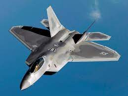

In [4]:
from PIL import Image

im = Image.open(path + 'F-22_Raptor/image_1.jpg')
im.to_thumb(128,128)

In [5]:
from fastai.vision.all import *
filenames = get_image_files(path)
filenames

(#819) [Path('data/F-1117_Nighthawk/image_1.jpg'),Path('data/F-1117_Nighthawk/image_10.jpg'),Path('data/F-1117_Nighthawk/image_100.jpg'),Path('data/F-1117_Nighthawk/image_101.jpg'),Path('data/F-1117_Nighthawk/image_102.jpg'),Path('data/F-1117_Nighthawk/image_103.jpg'),Path('data/F-1117_Nighthawk/image_104.jpg'),Path('data/F-1117_Nighthawk/image_105.jpg'),Path('data/F-1117_Nighthawk/image_107.jpg'),Path('data/F-1117_Nighthawk/image_108.jpg')...]

Sanity check on images. Corrupt images check.

In [6]:
failed = verify_images(filenames)
failed

(#0) []

Create own DataLoaders object --> data block API

In [7]:
# Create a DataBlock
fighterjets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [8]:
dls = fighterjets.dataloaders(path)

d:\school23_24\.venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


Show labeled images

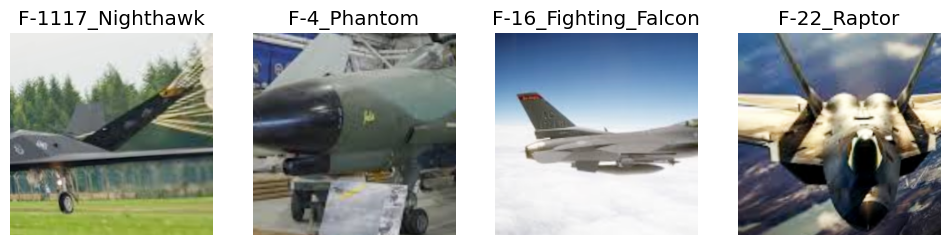

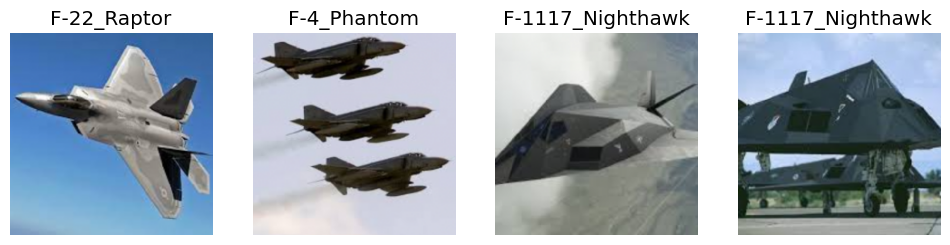

In [9]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

Test model using resnet

In [11]:
resnet50_model = vision_learner(dls, resnet50, metrics=error_rate)
resnet50_model.fine_tune(50)

epoch,train_loss,valid_loss,error_rate,time
0,2.295990,0.991687,0.343558,01:03


epoch,train_loss,valid_loss,error_rate,time
0,1.118451,0.890061,0.300613,01:20
1,1.056738,0.794418,0.294479,01:20
2,0.985922,0.779701,0.300613,01:20
3,0.905485,0.750891,0.269939,01:20
4,0.828336,0.735880,0.263804,01:19
5,0.753506,0.756102,0.269939,01:21
6,0.686364,0.761303,0.245399,01:19
7,0.596669,0.690712,0.233129,01:18
8,0.522624,0.619875,0.208589,01:18
9,0.468864,0.607426,0.214724,01:17


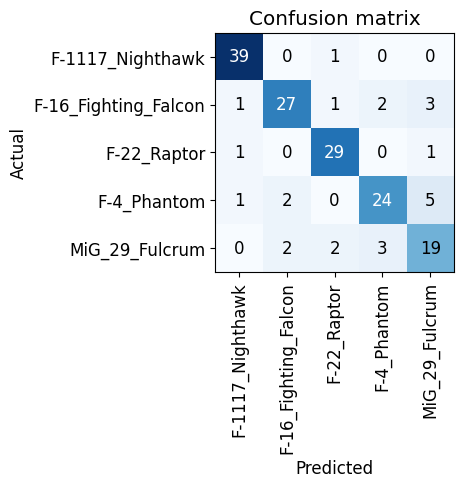

In [12]:
interp = ClassificationInterpretation.from_learner(resnet50_model)
interp.plot_confusion_matrix()

In [ ]:
interp = ClassificationInterpretation.from_learner(our_out_of_the_box_model)
interp.plot_confusion_matrix()

d:\school23_24\.venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


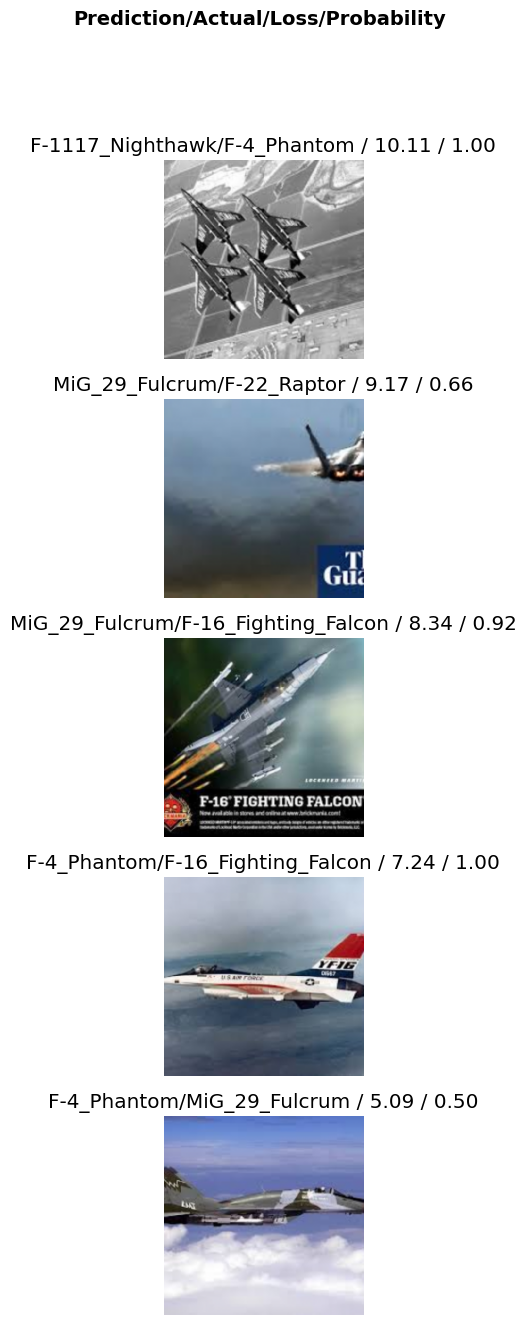

In [13]:
interp.plot_top_losses(5, nrows=5)

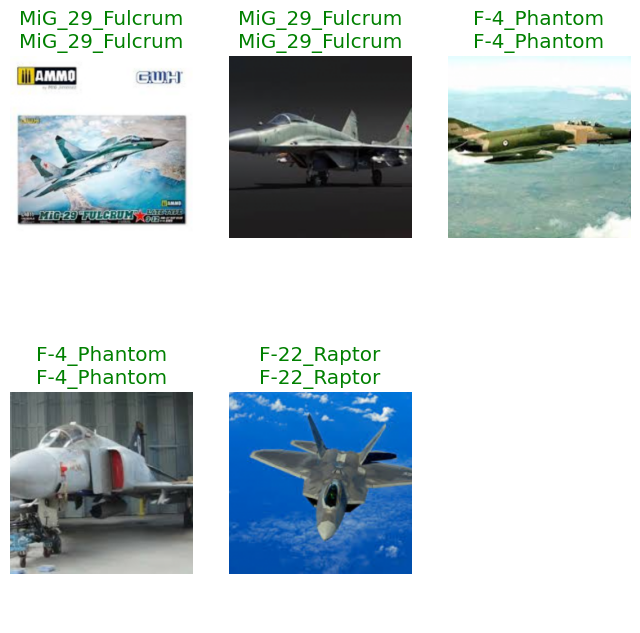

In [14]:
resnet50_model.show_results(max_n=5, figsize=(8,8))

In [15]:
confusion_matrix  = interp.confusion_matrix()

In [ ]:
accuracies_per_class = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)

class_names = resnet50_model.dls.vocab

# Print accuracy per class
print('Accuracy per class:')
for i, accuracy in enumerate(accuracies_per_class):
    print(f'{class_names[i]}: {accuracy * 100:.2f}%')

Accuracy per class:
F-1117_Nighthawk: 95.00%
F-16_Fighting_Falcon: 79.41%
F-22_Raptor: 83.87%
F-4_Phantom: 71.88%
MiG_29_Fulcrum: 65.38%


In [16]:
accuracies_per_class = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)

class_names = resnet50_model.dls.vocab

# Print accuracy per class
print('Accuracy per class:')
for i, accuracy in enumerate(accuracies_per_class):
    print(f'{class_names[i]}: {accuracy * 100:.2f}%')

Accuracy per class:
F-1117_Nighthawk: 97.50%
F-16_Fighting_Falcon: 79.41%
F-22_Raptor: 93.55%
F-4_Phantom: 75.00%
MiG_29_Fulcrum: 73.08%


In [30]:
resnet50_model.export("./models/model50")

In [31]:
loaded_model = load_learner("models/model50")

In [32]:
loaded_model.predict(path + 'F-22_Raptor/image_1.jpg')

d:\school23_24\.venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('F-22_Raptor',
 tensor(2),
 tensor([1.6581e-08, 1.3881e-09, 1.0000e+00, 2.6660e-11, 1.9414e-07]))